In [2]:
from pathlib import Path
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans, Birch, OPTICS

2024-09-25 16:49:23.282155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 16:49:23.318736: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
jfunc_all_data = xr.load_dataset("./data/jfunction_data_med.nc")
X_raw = jfunc_all_data.v.to_numpy()
X_raw_0 = X_raw[0, ~np.any(np.isnan(X_raw[0]), axis=(1,2))]
X_raw_1 = X_raw[1, ~np.any(np.isnan(X_raw[1]), axis=(1,2))]
X_raw_2 = X_raw[2, ~np.any(np.isnan(X_raw[2]), axis=(1,2))]
X = np.concatenate([X_raw_0, X_raw_1, X_raw_2])
X = X.transpose((0,2,1))
y_base = np.concatenate([np.zeros(X_raw_0.shape[0], dtype=int), np.ones(X_raw_1.shape[0], dtype=int), np.full(X_raw_2.shape[0], 2)]).reshape((-1, 1))
oh_enc = OneHotEncoder(sparse_output=False)
y = oh_enc.fit_transform(y_base)
X_train_base, X_test_base, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
abs_max = np.abs(X_train_base - 1).max()
X_train = (X_train_base - 1)/abs_max
X_test = (X_test_base - 1)/abs_max

In [4]:
if Path("./models/conv12_median.h5").is_file():
    model = keras.models.load_model("./models/conv12_median.h5")
else:
    x_input = keras.Input(X.shape[1:])
    x = x_input
    x = keras.layers.Conv1D(64, 5, padding="same", activation='relu')(x)
    x = keras.layers.MaxPooling1D()(x)
    x = keras.layers.Conv1D(32, 5, padding="same", activation='relu')(x)
    x = keras.layers.MaxPooling1D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(3, activation='softmax')(x)
    model = keras.Model(x_input, x)

    optimizer = keras.optimizers.RMSprop(1e-5)
    model.compile(optimizer=optimizer, loss="bce")
    model.summary()

    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=5000, validation_split=0.15, callbacks=[early_stopping])

2024-09-25 16:49:23.910803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-25 16:49:23.920754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-25 16:49:23.920850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-25 16:49:23.921113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

In [5]:
if not Path("./models/conv12_median.h5").is_file():
    history_curve = history.history
    history_curve["epoch"] = list(range(len(history_curve["loss"])))
    fig, ax = plt.subplots()
    sns.lineplot(history_curve, x="epoch", y="loss", ax=ax)
    sns.lineplot(history_curve, x="epoch", y="val_loss", ax=ax)
    plt.show()

In [6]:
if not Path("./models/conv12_median.h5").is_file():
    model.save("./models/conv12_median.h5", overwrite=True)

2024-09-25 16:49:24.681355: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


456/579 [======================>.......] - ETA: 0s

2024-09-25 16:49:25.191071: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


145/145 [==============================] - 0s 370us/step


[Text(0.5, 1.0, 'Test')]

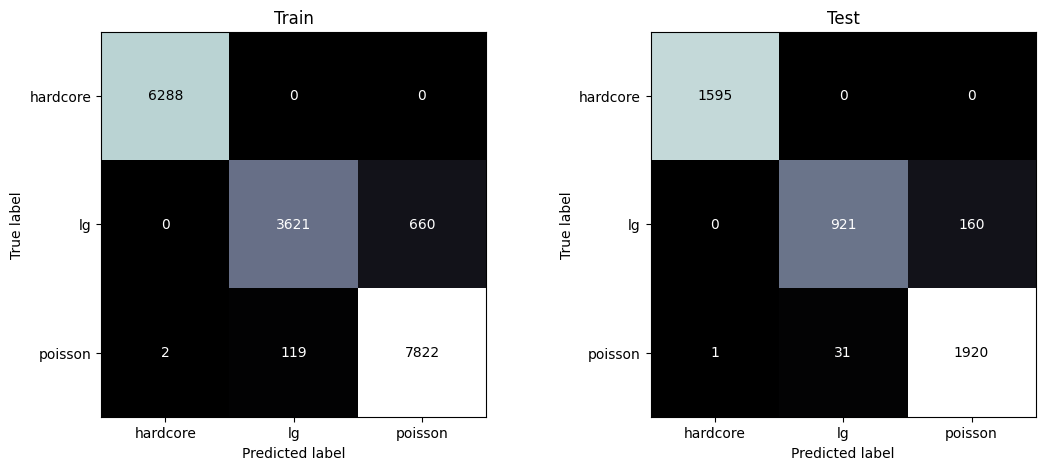

In [7]:
pred_train = model.predict(X_train)
y_train_disp = oh_enc.inverse_transform(y_train)
pred_train_disp = oh_enc.inverse_transform(pred_train)

pred_test = model.predict(X_test)
y_test_disp = oh_enc.inverse_transform(y_test)
pred_test_disp = oh_enc.inverse_transform(pred_test)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ConfusionMatrixDisplay.from_predictions(y_train_disp, pred_train_disp, ax=ax[0], colorbar=False, cmap="bone", display_labels=["hardcore", "lg", "poisson"])
ax[0].set(title="Train")
ConfusionMatrixDisplay.from_predictions(y_test_disp, pred_test_disp, ax=ax[1], colorbar=False, cmap="bone", display_labels=["hardcore", "lg", "poisson"])
ax[1].set(title="Test")

# Misclassification analysis

## Visualization of data

In [8]:
y_train_labels = y_train_disp.flatten()
pred_train_labels = pred_train_disp.flatten()
np.count_nonzero((y_train_labels == 1) & (pred_train_labels == 2)), np.count_nonzero((y_train_labels == 2) & (pred_train_labels == 1))

(660, 119)

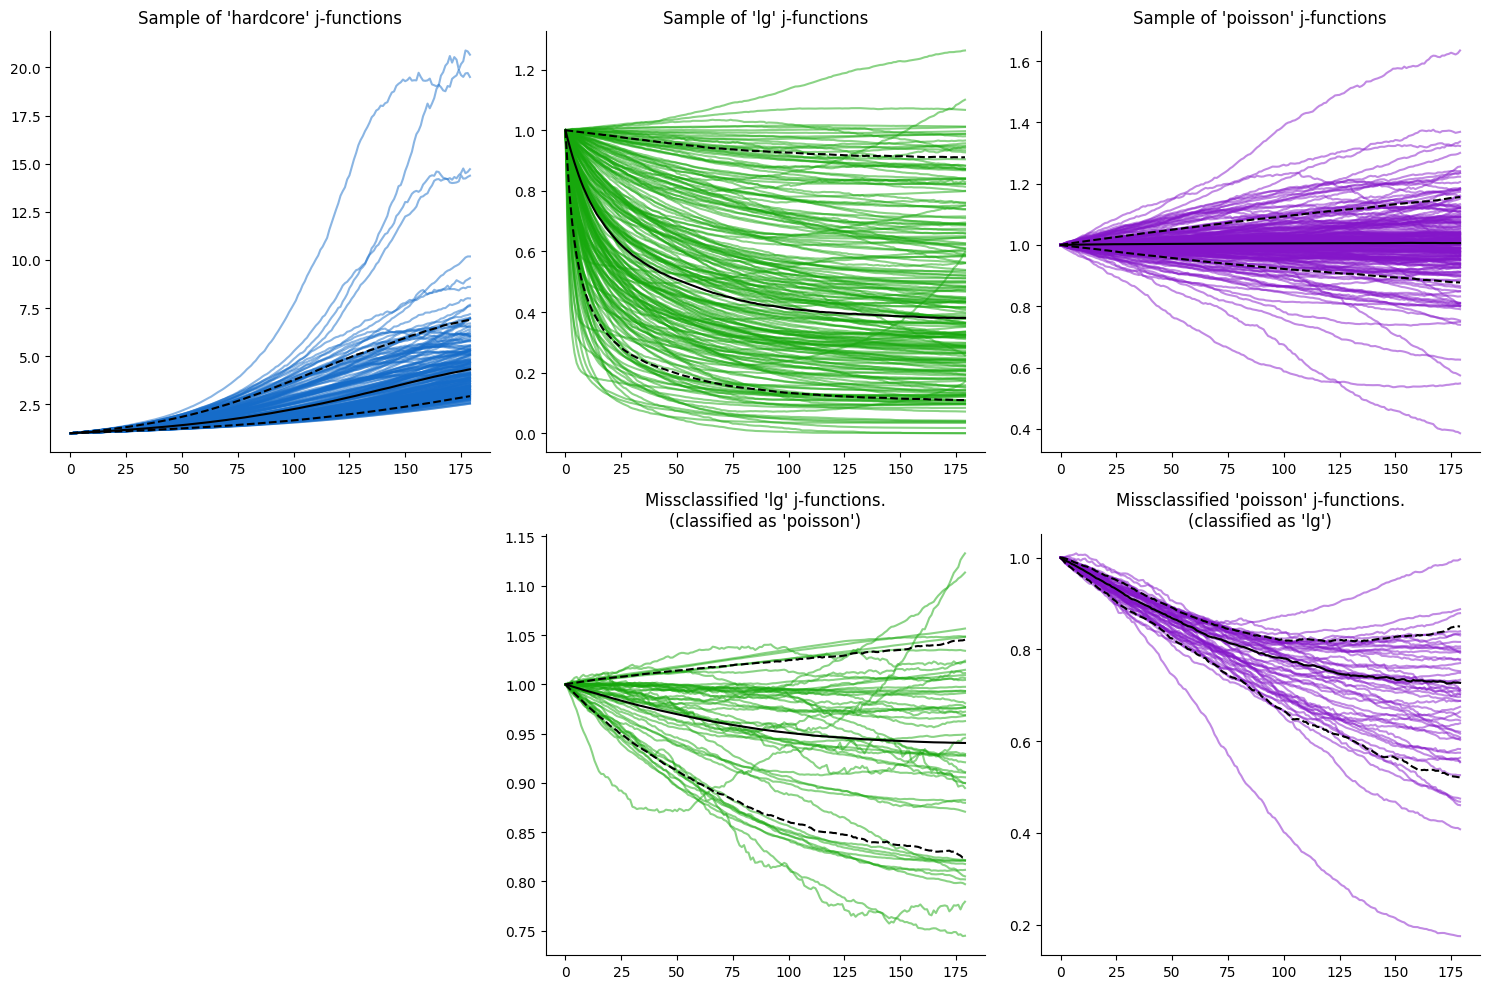

In [9]:
n_samples = 200
# n_samples = 100000
n_samples_miss = 50

hardcore_real = X_train_base[y_train_labels == 0]
chosen = np.random.permutation(hardcore_real.shape[0])[:n_samples]
hardcore_real_sample = hardcore_real[chosen].squeeze().T

lg_real = X_train_base[y_train_labels == 1]
chosen = np.random.permutation(lg_real.shape[0])[:n_samples]
lg_real_sample = lg_real[chosen].squeeze().T

poisson_real = X_train_base[y_train_labels == 2]
chosen = np.random.permutation(poisson_real.shape[0])[:n_samples]
poisson_real_sample = poisson_real[chosen].squeeze().T

lg_missed = X_train_base[(y_train_labels == 1) & (pred_train_labels == 2)]
chosen = np.random.permutation(lg_missed.shape[0])[:n_samples_miss]
lg_missed_sample = lg_missed[chosen].squeeze().T

poisson_missed = X_train_base[(y_train_labels == 2) & (pred_train_labels == 1)]
chosen = np.random.permutation(poisson_missed.shape[0])[:n_samples_miss]
poisson_missed_sample = poisson_missed[chosen].squeeze().T

fig, ax = plt.subplots(2, 3, figsize=(15,10))

ax[0,0].plot(np.arange(180), hardcore_real_sample, alpha=0.5, color="#166cc9")
ax[0,0].plot(np.arange(180), np.quantile(hardcore_real, 0.9, axis=0), ls="--", color="black", label="90th percentile")
ax[0,0].plot(np.arange(180), np.median(hardcore_real, axis=0), color="black", label="median")
ax[0,0].plot(np.arange(180), np.quantile(hardcore_real, 0.1, axis=0), ls="--", color="black", label="10th percentile")
ax[0,0].set(title="Sample of 'hardcore' j-functions") 
ax[0,1].plot(np.arange(180), lg_real_sample, alpha=0.5, color="#17a80d")
ax[0,1].plot(np.arange(180), np.quantile(lg_real, 0.9, axis=0), ls="--", color="black", label="90th percentile")
ax[0,1].plot(np.arange(180), np.median(lg_real, axis=0), color="black", label="median")
ax[0,1].plot(np.arange(180), np.quantile(lg_real, 0.1, axis=0), ls="--", color="black", label="10th percentile")
ax[0,1].set(title="Sample of 'lg' j-functions")
ax[0,2].plot(np.arange(180), poisson_real_sample, alpha=0.5, color="#8416c9")
ax[0,2].plot(np.arange(180), np.quantile(poisson_real, 0.9, axis=0), ls="--", color="black", label="90th percentile")
ax[0,2].plot(np.arange(180), np.median(poisson_real, axis=0), color="black", label="median")
ax[0,2].plot(np.arange(180), np.quantile(poisson_real, 0.1, axis=0), ls="--", color="black", label="10th percentile")
ax[0,2].set(title="Sample of 'poisson' j-functions")

fig.delaxes(ax[1,0])
ax[1,1].plot(np.arange(180), lg_missed_sample, alpha=0.5, color="#17a80d")
ax[1,1].plot(np.arange(180), np.quantile(lg_missed.squeeze(), 0.9, axis=0), ls="--", color="black")
ax[1,1].plot(np.arange(180), np.mean(lg_missed.squeeze(), axis=0), color="black")
ax[1,1].plot(np.arange(180), np.quantile(lg_missed.squeeze(), 0.1, axis=0), ls="--", color="black")
ax[1,1].set(title="Missclassified 'lg' j-functions.\n(classified as 'poisson')")
# ax[1,1].set(ylim=ax[0,1].get_ylim())
ax[1,2].plot(np.arange(180), poisson_missed_sample, alpha=0.5, color="#8416c9")
ax[1,2].plot(np.arange(180), np.quantile(poisson_missed.squeeze(), 0.9, axis=0), ls="--", color="black")
ax[1,2].plot(np.arange(180), np.median(poisson_missed.squeeze(), axis=0), color="black")
ax[1,2].plot(np.arange(180), np.quantile(poisson_missed.squeeze(), 0.1, axis=0), ls="--", color="black")
ax[1,2].set(title="Missclassified 'poisson' j-functions.\n(classified as 'lg')")
# ax[1,2].set(ylim=ax[0,2].get_ylim())

sns.despine()
plt.tight_layout()
plt.show()

## Dimension reduction

In [10]:
dim_red = PCA(n_components=2, whiten=True)
X_train_pca = dim_red.fit_transform(X_train_base.squeeze())

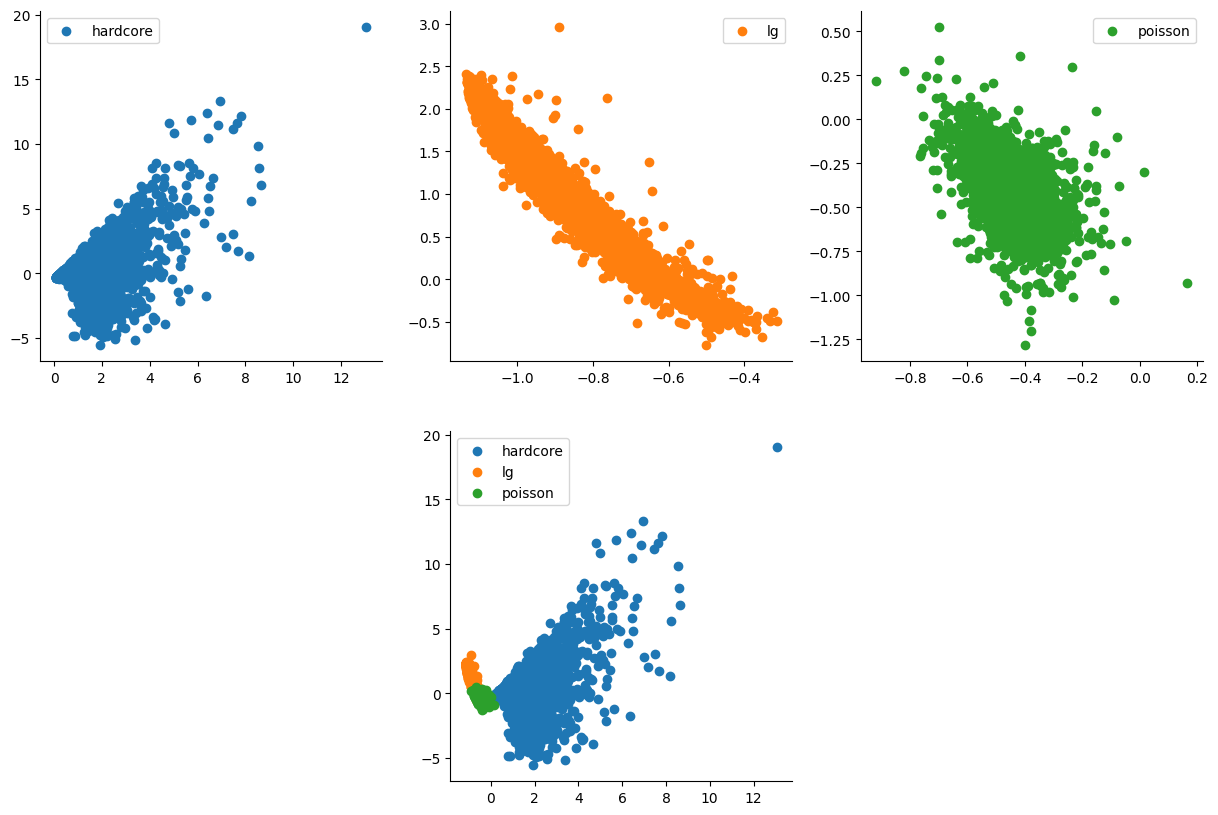

In [11]:
n_samples = 100000
# n_samples = 1000

sample_idx_pca = np.random.permutation(X_train_pca.shape[0])[:n_samples]
X_train_pca_sample = X_train_pca[sample_idx_pca]
y_train_sample = y_train_labels[sample_idx_pca]

fig, ax = plt.subplots(2, 3, figsize=(15,10))
ax[1,1].scatter(X_train_pca_sample[y_train_sample == 0, 0], X_train_pca_sample[y_train_sample == 0, 1], label="hardcore")
ax[1,1].scatter(X_train_pca_sample[y_train_sample == 1, 0], X_train_pca_sample[y_train_sample == 1, 1], label="lg")
ax[1,1].scatter(X_train_pca_sample[y_train_sample == 2, 0], X_train_pca_sample[y_train_sample == 2, 1], label="poisson")
ax[1,1].legend()
ax[0,0].scatter(X_train_pca_sample[y_train_sample == 0, 0], X_train_pca_sample[y_train_sample == 0, 1], color="C0", label="hardcore")
ax[0,0].legend()
ax[0,1].scatter(X_train_pca_sample[y_train_sample == 1, 0], X_train_pca_sample[y_train_sample == 1, 1], color="C1", label="lg")
ax[0,1].legend()
ax[0,2].scatter(X_train_pca_sample[y_train_sample == 2, 0], X_train_pca_sample[y_train_sample == 2, 1], color="C2", label="poisson")
ax[0,2].legend()
fig.delaxes(ax[1,0])
fig.delaxes(ax[1,2])
plt.legend()
sns.despine()
plt.show()

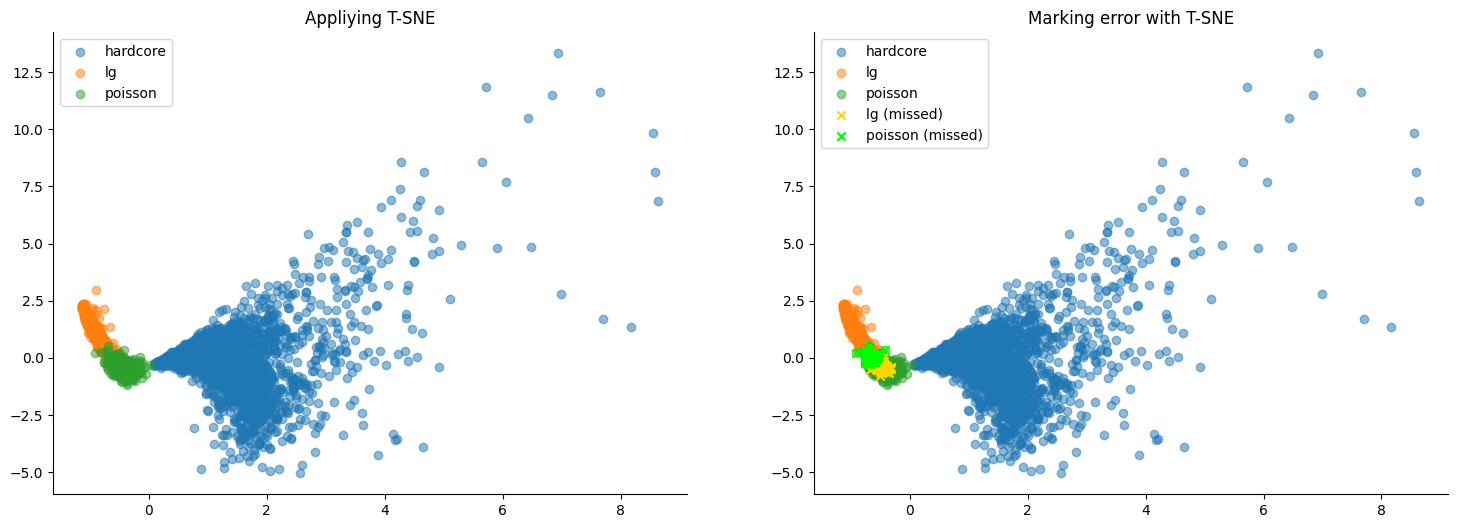

In [12]:
n_samples = 10000
# X_train_pca = dim_red_pca.transform(X_train_base.squeeze())
sample_idx_pca = np.random.permutation(X_train_pca.shape[0])[:n_samples]
X_train_pca_sample = X_train_pca[sample_idx_pca]
y_train_sample = y_train_labels[sample_idx_pca]

X_train_pca_missed_lg = X_train_pca[(y_train_labels == 1) & (pred_train_labels == 2)]
sample_idx_lgm = np.random.permutation(X_train_pca_missed_lg.shape[0])[:n_samples]
X_train_pca_missed_lg_sample = X_train_pca_missed_lg[sample_idx_lgm]

X_train_pca_missed_poisson = X_train_pca[(y_train_labels == 2) & (pred_train_labels == 1)]
sample_idx_poism = np.random.permutation(X_train_pca_missed_poisson.shape[0])[:n_samples]
X_train_pca_missed_poisson_sample = X_train_pca_missed_poisson[sample_idx_poism]

fig, ax = plt.subplots(1, 2, figsize=(18,6))
# scatter1 = ax.scatter(X_train_pca_sample[:, 0], X_train_pca_sample[:, 1], c=y_train_labels[sample_idx_pca], cmap="Set3", label=["a", "b", "c"])
ax[0].scatter(X_train_pca_sample[y_train_sample == 0, 0], X_train_pca_sample[y_train_sample == 0, 1], alpha=0.5, label="hardcore")
ax[0].scatter(X_train_pca_sample[y_train_sample == 1, 0], X_train_pca_sample[y_train_sample == 1, 1], alpha=0.5, label="lg")
ax[0].scatter(X_train_pca_sample[y_train_sample == 2, 0], X_train_pca_sample[y_train_sample == 2, 1], alpha=0.5, label="poisson")
ax[0].set(title="Appliying T-SNE")
ax[0].legend()
ax[1].scatter(X_train_pca_sample[y_train_sample == 0, 0], X_train_pca_sample[y_train_sample == 0, 1], alpha=0.5, label="hardcore")
ax[1].scatter(X_train_pca_sample[y_train_sample == 1, 0], X_train_pca_sample[y_train_sample == 1, 1], alpha=0.5, label="lg")
ax[1].scatter(X_train_pca_sample[y_train_sample == 2, 0], X_train_pca_sample[y_train_sample == 2, 1], alpha=0.5, label="poisson")
ax[1].scatter(X_train_pca_missed_lg_sample[:,0], X_train_pca_missed_lg_sample[:,1], color="gold", label="lg (missed)", marker="x")
ax[1].scatter(X_train_pca_missed_poisson[:,0], X_train_pca_missed_poisson[:,1], color="lime", label="poisson (missed)", marker="x")
ax[1].set(title="Marking error with T-SNE")
ax[1].legend()
sns.despine()
plt.show()

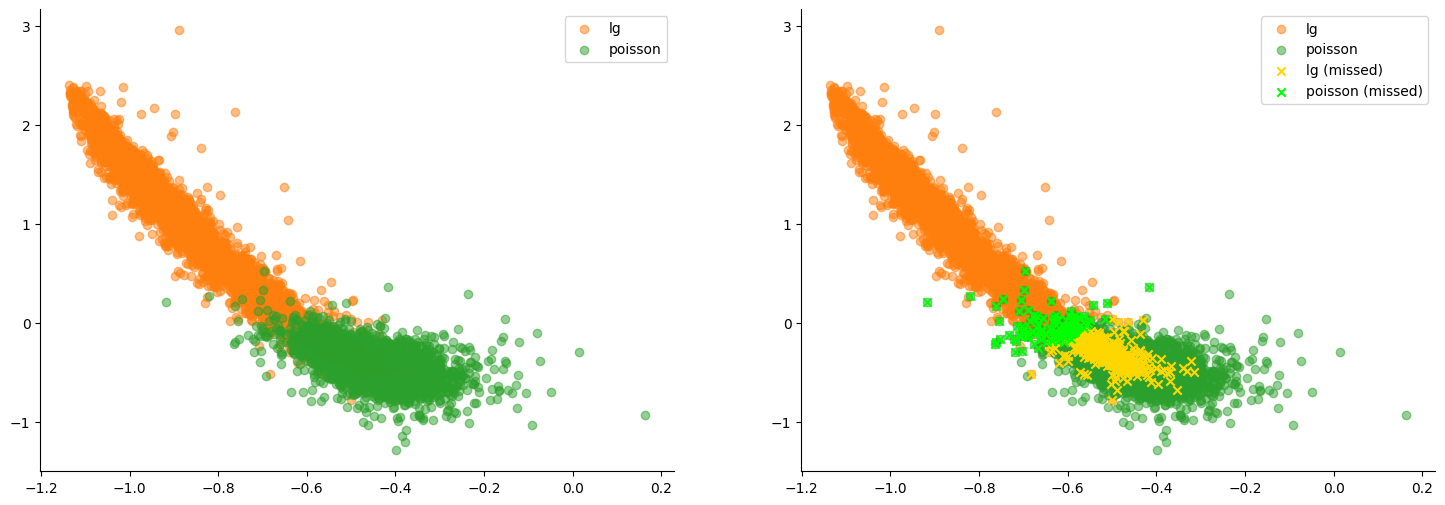

In [13]:
n_samples = 100000

X_train_pca = dim_red.fit_transform(X_train_base.squeeze())
sample_idx_pca = np.random.permutation(X_train_pca.shape[0])[:n_samples]
X_train_pca_sample = X_train_pca[sample_idx_pca]
y_train_sample = y_train_labels[sample_idx_pca]

X_train_pca_missed_lg = X_train_pca[(y_train_labels == 1) & (pred_train_labels == 2)]
sample_idx_lgm = np.random.permutation(X_train_pca_missed_lg.shape[0])[:n_samples]
X_train_pca_missed_lg_sample = X_train_pca_missed_lg[sample_idx_lgm]

X_train_pca_missed_poisson = X_train_pca[(y_train_labels == 2) & (pred_train_labels == 1)]
sample_idx_poism = np.random.permutation(X_train_pca_missed_poisson.shape[0])[:n_samples]
X_train_pca_missed_poisson_sample = X_train_pca_missed_poisson[sample_idx_poism]

fig, ax = plt.subplots(1, 2, figsize=(18,6))
# scatter1 = ax.scatter(X_train_pca_sample[:, 0], X_train_pca_sample[:, 1], c=y_train_labels[sample_idx_pca], cmap="Set3", label=["a", "b", "c"])
ax[0].scatter(X_train_pca_sample[y_train_sample == 1, 0], X_train_pca_sample[y_train_sample == 1, 1], alpha=0.5, color="C1", label="lg")
ax[0].scatter(X_train_pca_sample[y_train_sample == 2, 0], X_train_pca_sample[y_train_sample == 2, 1], alpha=0.5, color="C2", label="poisson")
ax[0].legend()
ax[1].scatter(X_train_pca_sample[y_train_sample == 1, 0], X_train_pca_sample[y_train_sample == 1, 1], alpha=0.5, color="C1", label="lg")
ax[1].scatter(X_train_pca_sample[y_train_sample == 2, 0], X_train_pca_sample[y_train_sample == 2, 1], alpha=0.5, color="C2", label="poisson")
ax[1].scatter(X_train_pca_missed_lg_sample[:,0], X_train_pca_missed_lg_sample[:,1], color="gold", label="lg (missed)", marker="x")
ax[1].scatter(X_train_pca_missed_poisson[:,0], X_train_pca_missed_poisson[:,1], color="lime", label="poisson (missed)", marker="x")
ax[1].legend()
sns.despine()
plt.show()


In [14]:
dim_red_tsne = TSNE(n_components=2)
X_train_tsne = dim_red_tsne.fit_transform(X_train_base.squeeze())

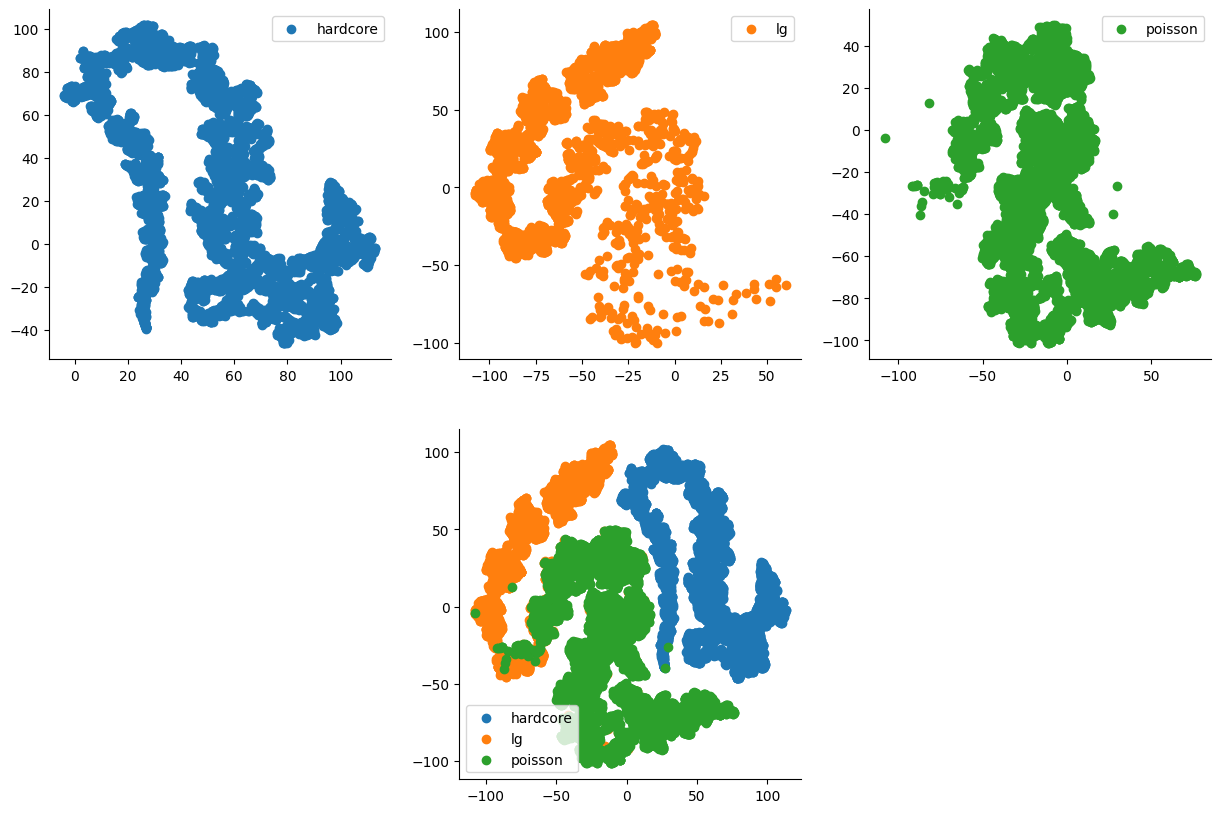

In [15]:
n_samples = 100000
# n_samples = 1000

sample_idx_tsne = np.random.permutation(X_train_tsne.shape[0])[:n_samples]
X_train_tsne_sample = X_train_tsne[sample_idx_tsne]
y_train_sample = y_train_labels[sample_idx_tsne]

fig, ax = plt.subplots(2, 3, figsize=(15,10))
ax[1,1].scatter(X_train_tsne_sample[y_train_sample == 0, 0], X_train_tsne_sample[y_train_sample == 0, 1], label="hardcore")
ax[1,1].scatter(X_train_tsne_sample[y_train_sample == 1, 0], X_train_tsne_sample[y_train_sample == 1, 1], label="lg")
ax[1,1].scatter(X_train_tsne_sample[y_train_sample == 2, 0], X_train_tsne_sample[y_train_sample == 2, 1], label="poisson")
ax[1,1].legend()
ax[0,0].scatter(X_train_tsne_sample[y_train_sample == 0, 0], X_train_tsne_sample[y_train_sample == 0, 1], color="C0", label="hardcore")
ax[0,0].legend()
ax[0,1].scatter(X_train_tsne_sample[y_train_sample == 1, 0], X_train_tsne_sample[y_train_sample == 1, 1], color="C1", label="lg")
ax[0,1].legend()
ax[0,2].scatter(X_train_tsne_sample[y_train_sample == 2, 0], X_train_tsne_sample[y_train_sample == 2, 1], color="C2", label="poisson")
ax[0,2].legend()
fig.delaxes(ax[1,0])
fig.delaxes(ax[1,2])
plt.legend()
sns.despine()
plt.show()

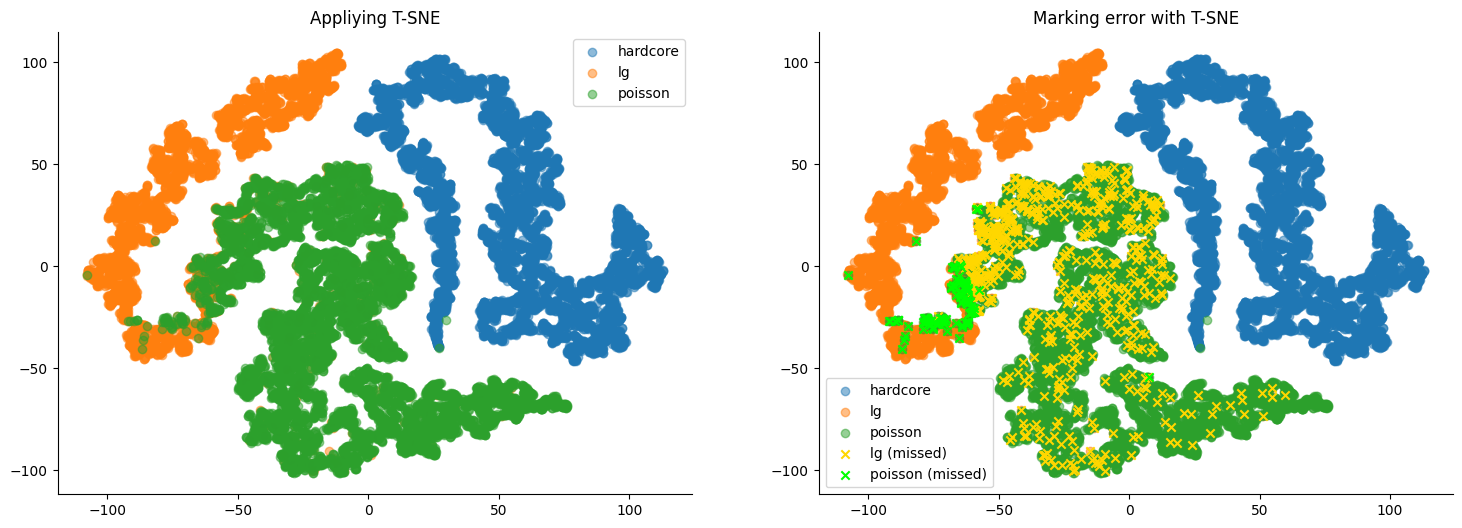

In [16]:
n_samples = 100000
# X_train_tsne = dim_red_tsne.transform(X_train_base.squeeze())
sample_idx_tsne = np.random.permutation(X_train_tsne.shape[0])[:n_samples]
X_train_tsne_sample = X_train_tsne[sample_idx_tsne]
y_train_sample = y_train_labels[sample_idx_tsne]

X_train_tsne_missed_lg = X_train_tsne[(y_train_labels == 1) & (pred_train_labels == 2)]
sample_idx_lgm = np.random.permutation(X_train_tsne_missed_lg.shape[0])[:n_samples]
X_train_tsne_missed_lg_sample = X_train_tsne_missed_lg[sample_idx_lgm]

X_train_tsne_missed_poisson = X_train_tsne[(y_train_labels == 2) & (pred_train_labels == 1)]
sample_idx_poism = np.random.permutation(X_train_tsne_missed_poisson.shape[0])[:n_samples]
X_train_tsne_missed_poisson_sample = X_train_tsne_missed_poisson[sample_idx_poism]

fig, ax = plt.subplots(1, 2, figsize=(18,6))
# scatter1 = ax.scatter(X_train_tsne_sample[:, 0], X_train_tsne_sample[:, 1], c=y_train_labels[sample_idx_tsne], cmap="Set3", label=["a", "b", "c"])
ax[0].scatter(X_train_tsne_sample[y_train_sample == 0, 0], X_train_tsne_sample[y_train_sample == 0, 1], alpha=0.5, label="hardcore")
ax[0].scatter(X_train_tsne_sample[y_train_sample == 1, 0], X_train_tsne_sample[y_train_sample == 1, 1], alpha=0.5, label="lg")
ax[0].scatter(X_train_tsne_sample[y_train_sample == 2, 0], X_train_tsne_sample[y_train_sample == 2, 1], alpha=0.5, label="poisson")
ax[0].set(title="Appliying T-SNE")
ax[0].legend()
ax[1].scatter(X_train_tsne_sample[y_train_sample == 0, 0], X_train_tsne_sample[y_train_sample == 0, 1], alpha=0.5, label="hardcore")
ax[1].scatter(X_train_tsne_sample[y_train_sample == 1, 0], X_train_tsne_sample[y_train_sample == 1, 1], alpha=0.5, label="lg")
ax[1].scatter(X_train_tsne_sample[y_train_sample == 2, 0], X_train_tsne_sample[y_train_sample == 2, 1], alpha=0.5, label="poisson")
ax[1].scatter(X_train_tsne_missed_lg_sample[:,0], X_train_tsne_missed_lg_sample[:,1], color="gold", label="lg (missed)", marker="x")
ax[1].scatter(X_train_tsne_missed_poisson[:,0], X_train_tsne_missed_poisson[:,1], color="lime", label="poisson (missed)", marker="x")
ax[1].set(title="Marking error with T-SNE")
ax[1].legend()
sns.despine()
plt.show()


## Clustering

### DBSCAN

In [29]:
cluster_model = DBSCAN(eps=0.5)
labels = cluster_model.fit_predict(X_train_base.squeeze())
n_clusters = len(set(cluster_model.labels_) - set([-1]))
n_outliers = list(cluster_model.labels_).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of outliers: {n_outliers} out of {X_train_base.shape[0]}")
print(f"Silhouette Coefficient: {metrics.silhouette_score(X_train_base.squeeze(), labels):.3f}")
print(f"Homogeneity: {metrics.homogeneity_score(y_train_labels, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(y_train_labels, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(y_train_labels, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y_train_labels, labels):.3f}")
print(f"Rand Index: {metrics.rand_score(y_train_labels, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(y_train_labels, labels):.3f}"
)

Number of clusters: 22
Number of outliers: 1676 out of 18512
Silhouette Coefficient: 0.517
Homogeneity: 0.592
Completeness: 0.690
V-measure: 0.637
Adjusted Rand Index: 0.502
Rand Index: 0.751
Adjusted Mutual Information: 0.637


In [19]:
# Ignore labels with few elements
labels_reduced = labels.copy()
values, counts = np.unique(labels, return_counts=True)
for v, count in zip(values[1:], counts[1:]):
    if count < 100:
        labels_reduced[labels == v] = -1

display(np.unique(labels, return_counts=True))
display(np.unique(labels_reduced, return_counts=True))

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21]),
 array([ 1676,  4435, 12193,     5,    24,     6,    13,    11,     5,
           32,     7,    24,     5,     7,    12,     5,     6,     6,
           12,     8,     5,    10,     5]))

(array([-1,  0,  1]), array([ 1884,  4435, 12193]))

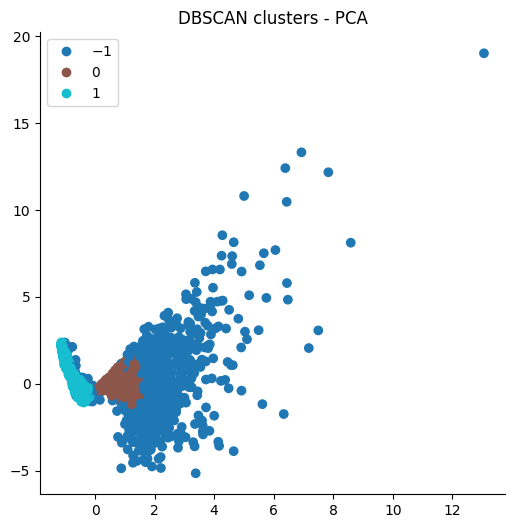

In [20]:
n_samples = 10000
sample_idx_pca = np.random.permutation(X_train_pca.shape[0])[:n_samples]
X_train_pca_sample = X_train_pca[sample_idx_pca]

fig, ax = plt.subplots(figsize=(6,6))
scatter = ax.scatter(X_train_pca_sample[:, 0], X_train_pca_sample[:, 1], c=labels_reduced[sample_idx_pca], cmap="tab10")
ax.legend(*scatter.legend_elements())
ax.set(title="DBSCAN clusters - PCA")
sns.despine()
plt.show()

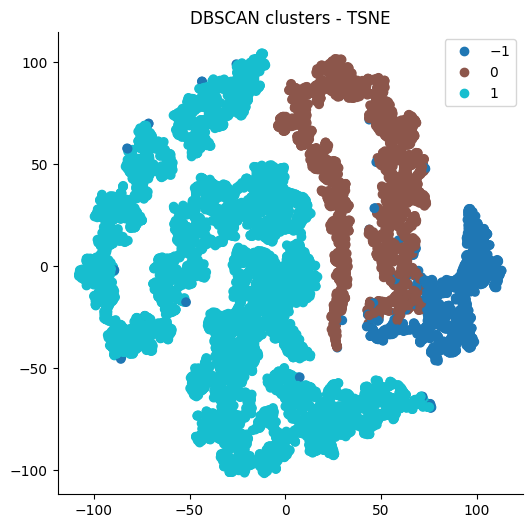

In [21]:
n_samples = 10000
sample_idx_tsne = np.random.permutation(X_train_tsne.shape[0])[:n_samples]
X_train_tsne_sample = X_train_tsne[sample_idx_tsne]

fig, ax = plt.subplots(figsize=(6,6))
scatter = ax.scatter(X_train_tsne_sample[:, 0], X_train_tsne_sample[:, 1], c=labels_reduced[sample_idx_tsne], cmap="tab10")
ax.legend(*scatter.legend_elements())
ax.set(title="DBSCAN clusters - TSNE")
sns.despine()
plt.show()

### KMeans

In [22]:
cluster_model = KMeans(n_clusters=3, n_init='auto')
labels = cluster_model.fit_predict(X_train_base.squeeze())
n_clusters = len(set(cluster_model.labels_) - set([-1]))
# n_outliers = list(cluster_model.labels_).count(-1)
print(f"Number of clusters: {n_clusters}")
# print(f"Number of outliers: {n_outliers} out of {X_train_base.shape[0]}")
print(f"Silhouette Coefficient: {metrics.silhouette_score(X_train_base.squeeze(), labels):.3f}")
print(f"Homogeneity: {metrics.homogeneity_score(y_train_labels, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(y_train_labels, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(y_train_labels, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y_train_labels, labels):.3f}")
print(f"Rand Index: {metrics.rand_score(y_train_labels, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(y_train_labels, labels):.3f}"
)

Number of clusters: 3
Silhouette Coefficient: 0.708
Homogeneity: 0.598
Completeness: 0.776
V-measure: 0.675
Adjusted Rand Index: 0.524
Rand Index: 0.760
Adjusted Mutual Information: 0.675


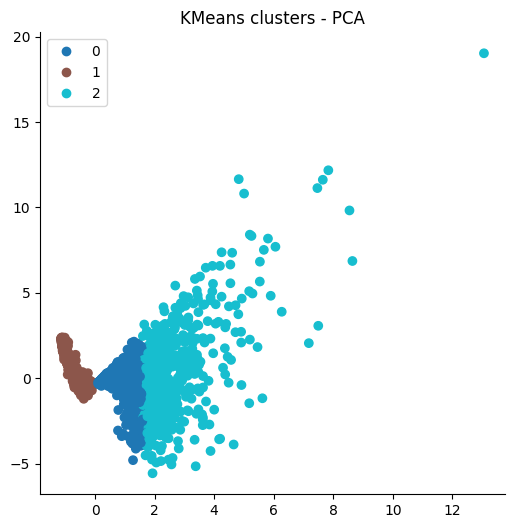

In [23]:
n_samples = 10000
sample_idx_pca = np.random.permutation(X_train_pca.shape[0])[:n_samples]
X_train_pca_sample = X_train_pca[sample_idx_pca]

fig, ax = plt.subplots(figsize=(6,6))
scatter = ax.scatter(X_train_pca_sample[:, 0], X_train_pca_sample[:, 1], c=labels[sample_idx_pca], cmap="tab10")
ax.legend(*scatter.legend_elements())
ax.set(title="KMeans clusters - PCA")
sns.despine()
plt.show()

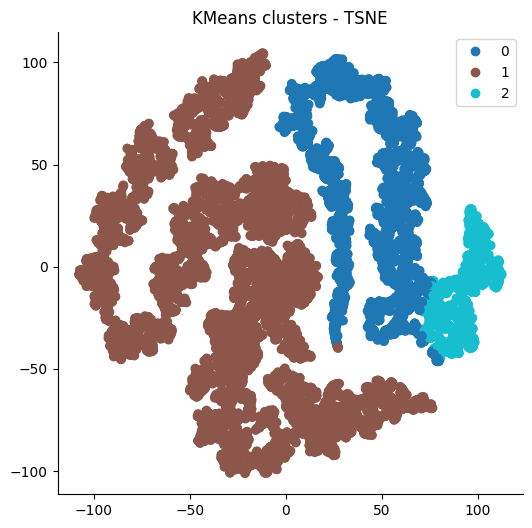

In [24]:
n_samples = 10000
sample_idx_tsne = np.random.permutation(X_train_tsne.shape[0])[:n_samples]
X_train_tsne_sample = X_train_tsne[sample_idx_tsne]

fig, ax = plt.subplots(figsize=(6,6))
scatter = ax.scatter(X_train_tsne_sample[:, 0], X_train_tsne_sample[:, 1], c=labels[sample_idx_tsne], cmap="tab10")
ax.legend(*scatter.legend_elements())
ax.set(title="KMeans clusters - TSNE")
sns.despine()
plt.show()